# 2016 VEST MI

### From Documentation:
Election results from the Michigan Department of State (https://miboecfr.nictusa.com/cgi-bin/cfr/precinct_srch.cgi)
Precinct shapefile from the Michigan Department of State (https://gis-michigan.opendata.arcgis.com/datasets/8ce0f3ce3ff74109ac02a26d34a0f4fc_1)

Michigan has cities split across counties. Two are relevant to their reported election results versus the precinct map (which did not make the split), Fenton and Richmond. Those precincts were merged to reflect the precinct map.

Most counties had "statistical adjustments" that were at the county level, rather than the precinct level. Only two were for party candidates (Huron and Kalkaka), and in those cases, two or fewer votes. The remaining cases were related to "other" votes. Due to the scattered nature of "other" votes, these votes are apportioned to precincts by the split of total votes of precincts within the county.

Detroit allows for absentee votes to be reported by Absentee Voter Counting Boards, which generally contain multiple precincts. These votes are apportioned to precincts by candidate in the same shares that the non-AVCB vote was split among precincts within a county. The linkage between election precinct and AVCB was provided by OpenElections via Derek Willis. Precinct 176 was listed as split between AVCB 37 and AVCB 158, the only precinct in the city that was listed as split. AVCB 158 has no other precinct assigned to it, so all votes went to precinct 176. However, this was a very low number of votes relative to the other AVCBs, so for ease of calculation, 176 was treated as a normal member of AVCB 37 in the disaggregation calculation described above.

G16PREDCli - Hillary Clinton (Democratic Party)
G16PRERTru - Donald J. Trump (Republican Party)
G16PREGSte - Jill Stein (Green Party)
G16PRELJoh - Gary Johnson (Libertarian Party)
G16PREOth - Other Candidates/Write-in Votes


**Files + Sources:** 

2016GEN.zip: Election precinct results from the Michigan Department of State (https://miboecfr.nictusa.com/cgi-bin/cfr/precinct_srch.cgi)

2016_Voting_Precincts-shp.zip: Precinct shapefile from the Michigan Department of State (https://gis-michigan.opendata.arcgis.com/datasets/8ce0f3ce3ff74109ac02a26d34a0f4fc_1)

mi_2016.zip: VEST final file (https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/NH5S2I/4KOZRU&version=46.0)

documentation_2016.txt: VEST's documentation on their 2016 work, all included, not just MI (https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/NH5S2I/A652IT&version=46.0)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load Partner File

In [2]:
gdfv = gpd.read_file('./raw-from-source/mi_2016/mi_2016.shp')
gdfv.head()

,VTD2016,Label,G16PREDCli,G16PRERTru,G16PREGSte,G16PRELJoh,G16PREOth,geometry
0,1632100000001,City of Dearborn,581,93,17,11,1,"POLYGON ((-83.14843 42.34469, -83.14861 42.343..."
1,1632100000002,City of Dearborn,560,95,23,9,3,"POLYGON ((-83.16029 42.34644, -83.16027 42.344..."
2,1632100000003,City of Dearborn,756,171,52,13,5,"POLYGON ((-83.16699 42.34247, -83.16815 42.342..."
3,1632100000004,City of Dearborn,406,70,17,8,1,"POLYGON ((-83.17687 42.34399, -83.17806 42.343..."
4,1632100000005,City of Dearborn,453,68,15,9,0,"POLYGON ((-83.18665 42.34561, -83.18657 42.343..."


# Shapefile

In [3]:
## Load, Project
shp = gpd.read_file('./raw-from-source/2016_Voting_Precincts/2016_Voting_Precincts.shp')
crs = gdfv.crs
shp = shp.to_crs(crs)
shp.head()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((-83.14842 42.34468, -83.14859 42.343..."
1,2,3889,1632100000002,163,21000,2016,City of Dearborn,1.058362e+06,4621.388992,"POLYGON ((-83.16028 42.34643, -83.16025 42.344..."
2,3,3890,1632100000003,163,21000,2016,City of Dearborn,1.488846e+06,4909.715171,"POLYGON ((-83.16698 42.34246, -83.16814 42.342..."
3,4,3891,1632100000004,163,21000,2016,City of Dearborn,1.187165e+06,4354.743602,"POLYGON ((-83.17686 42.34398, -83.17805 42.343..."
4,5,3892,1632100000005,163,21000,2016,City of Dearborn,1.133548e+06,5460.202887,"POLYGON ((-83.18664 42.34560, -83.18656 42.343..."


# Election Results

In [4]:
## Load + Process format

df = pd.read_csv('./raw-from-source/2016GEN/2016vote.txt', delimiter = '\t', header = None)
#columns defined in documentation
df.columns = ['election_year','election_type','office_code','district_code',
            'status_code','candidate_id','county_code','city_town_code','ward_number',
            'precinct_number','precinct_label','precinct_votes','na_col']
#Processing
#Filter to office code `1` for president
df = df[df['office_code'] == 1]

#Using the file `2016name.txt` to figure out these candidate codes: 
#- -1130:Stein,-1128:Clinton,-1110:Trump,-1101:Johnson

#Have to replace NaNs in `precinct_label` with empty strings so that we can use it as an index in the pivot
df['precinct_label'] = df['precinct_label'].replace(np.nan, '', regex = True)
## PIVOT RESULTS
df_pivot = df.pivot_table(index = ['county_code','city_town_code','ward_number','precinct_number','precinct_label'],
                         columns = ['candidate_id'],
                        values = ['precinct_votes'],
                         aggfunc = 'sum')
df_pivot.reset_index(inplace = True)

vote_cols_other = [( 'precinct_votes', -1142),
            ( 'precinct_votes', -1141),
            ( 'precinct_votes', -1140),
            ( 'precinct_votes', -1139),
            ( 'precinct_votes', -1137),
            ( 'precinct_votes', -1136),
            ( 'precinct_votes', -1135),
            ( 'precinct_votes', -1112),
            ( 'precinct_votes', -1108)]
df_pivot['G16PREOth'] = 0
for col in vote_cols_other:
    df_pivot['G16PREOth'] = df_pivot['G16PREOth'] + df_pivot[col]
    df_pivot.drop(col[1], axis = 1, level = 1, inplace = True)
    
df_pivot.reset_index(inplace = True)
df_pivot.columns = ['candidate_id','county_code','city_town_code','ward_number','precinct_number','precinct_label',
                              'G16PREGSte','G16PREDCli','G16PRERTru','G16PRELJoh','G16PREOth']

### Cleaning Election Results

In [5]:
#### Add County Name
#The SOS results have county codes that are not FIPS codes. Pulled the `county.txt` file to a Sheet and lined it up with county fips codes from Wikipedia. Loading in this file created in Sheets. 
county_names = pd.read_csv('./raw-from-source/county_codes.csv', dtype = {'county_fips':'object'})
df_pivot = df_pivot.merge(county_names, on = 'county_code')

#### Add City/Township Name
#Loading in the `2016city.txt` file that has the corresponding names for the city codes in the election results file
city_codes = pd.read_csv('./raw-from-source/2016GEN/2016city.txt',delimiter='\t',header=None)
city_codes.columns = ['election_year','election_type','county_code','city_town_code','city_town_name','null']
city_codes.drop(['election_year','election_type','null'],axis=1,inplace=True)
df_pivot = df_pivot.merge(city_codes, on = ['county_code','city_town_code'])

## Validate Election Results at State and County Levels

### Validate statewide totals

In [6]:
data_columns = ["G16PREDCli","G16PRERTru","G16PREGSte","G16PRELJoh","G16PREOth"]

In [7]:
for race in data_columns:
    diff_val = sum(gdfv[race])-sum(df_pivot[race])
    if diff_val != 0:
        print(race+": "+str(diff_val), "\tVEST sum: ", sum(gdfv[race]), "\tRDH sum: ", sum(df_pivot[race]))
    else:
        print(race+": EQUAL - "+ str(sum(df_pivot[race])))

G16PREDCli: EQUAL - 2268839
G16PRERTru: EQUAL - 2279543
G16PREGSte: EQUAL - 51463
G16PRELJoh: EQUAL - 172136
G16PREOth: EQUAL - 27303


### Validate countywide totals

Note: We do not necessarily expect these to match exactly at this point given VEST's instructions:

Michigan has cities split across counties. Two are relevant to their reported election results versus the precinct map (which did not make the split), Fenton and Richmond. Those precincts were merged to reflect the precinct map.

In [8]:
#Add a county FIPS column to the VEST file
gdfv['county_fips'] = gdfv['VTD2016'].str.slice(stop=3)

diff_counties=[]
for i in data_columns:
    diff = df_pivot.groupby(['county_fips']).sum()[i]-gdfv.groupby(['county_fips']).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
print("All other races in all counties are equal")

G16PREDCli
049   -3
125    3
G16PRERTru
049   -9
099   -3
125    9
147    3
All other races in all counties are equal


## Validate Election Results at Precinct Level

### Look for unique identifier

In [9]:
#So, the elections file has 157 more unique identifiers than VEST's final file... Likely caused by satistical adjustments + AVCBs
print(set(gdfv.VTD2016) - set(shp.VTD2016))
print(set(shp.VTD2016) - set(gdfv.VTD2016))

set()
set()


- See that `gdfv`, the final VEST file and `shp` the raw shapefile have unique identifiers that match up perfectly.  
- Check `gdfv` `VTD2016` column to identify different components of the unique id  
- Check census all geocodes file and find that `City of Dearborn` has `county_fips` = 163, and `county subdiv`(MCDFIPS) = 21000  
- So, from `shp`, `Jurisdicti` is the `county subdiv`/MCDFIPS code  

### Read in Census File to get the MCDFIPs code and more

In [10]:
census = pd.read_csv('./raw-from-source/all-geocodes-v2016.csv')
censusmi = census[census['State Code (FIPS)'] == 26]
#After `Place Code` != 0, repeat values, so want to filter that out. Then see that # unique values = 1520 for County Sub, indicating same as `Juris` in `shp`
censusmi = censusmi[(censusmi['Place Code (FIPS)'] == 0) & (censusmi['County Subdivision Code (FIPS)'] != 0)]


- Census file uses "Charter Township" whereas election df just says "Township". Also, census file says "City City" in some places
- Seems like best bet is to make `Area Name`s consistent, make column with the county fips joined, then use dictionary to match to the `Juris` code
- Before removing all instances of charter from the censusmi, wanted to make sure df does not contain instances, it doesnt
`df_pivot[df_pivot['city_town_name'].str.contains('charter')]
df_pivot[df_pivot['city_town_name'].str.contains('CITY CITY')]`

### Clean census file to make match column

In [11]:
censusmi['city_town_name'] = censusmi['Area Name (including legal/statistical area description)'].str.replace('charter township', 'township')
censusmi['city_town_name'] = censusmi['city_town_name'].str.replace('City city', 'city')
censusmi['city_town_name'] = censusmi['city_town_name'].str.upper()

#set(censusmi['city_town_name'].str.upper()) - set(df_pivot['city_town_name'])
#set(df_pivot['city_town_name']) - set(censusmi['city_town_name'].str.upper())
#Use^ to create dictionary below

census_to_df_city_dict = {'COLDSPRINGS TOWNSHIP': 'COLD SPRINGS TOWNSHIP',
 'DEWITT CITY': 'DE WITT CITY',
 'DEWITT TOWNSHIP': 'DE WITT TOWNSHIP',
 'GUN PLAIN TOWNSHIP': 'GUNPLAIN TOWNSHIP',
 "L'ANSE TOWNSHIP": 'LANSE TOWNSHIP',
 'LAGRANGE TOWNSHIP': 'LA GRANGE TOWNSHIP',
 'PLEASANTVIEW TOWNSHIP': 'PLEASANT VIEW TOWNSHIP',
 'ST. JAMES TOWNSHIP': 'ST JAMES TOWNSHIP',
 'VILLAGE OF CLARKSTON CITY': 'CLARKSTON CITY',
 'VILLAGE OF GROSSE POINTE SHORES CITY': 'GROSSE POINTE SHORES CITY'}

censusmi.loc[censusmi['city_town_name'].isin(census_to_df_city_dict.keys()), 'city_town_name'] = censusmi.loc[censusmi['city_town_name'].isin(census_to_df_city_dict.keys()), 'city_town_name'].map(census_to_df_city_dict)
censusmi.loc[(censusmi['Area Name (including legal/statistical area description)'] == 'Village of Grosse Pointe Shores city')&(censusmi['County Code (FIPS)']==99), 'city_town_name'] = 'GROSS POINTE SHORES CITY'


### Translate Census file JURISDICTION code in to df
Now that the city town names match, I can create a dictionary - census file juris code to df. First I need a column in each with the county code + the city town name

In [12]:
censusmi['county_city_id'] = censusmi['County Code (FIPS)'].astype(str).str.zfill(3) + censusmi['city_town_name']
df_pivot['county_city_id'] = df_pivot['county_fips'] + df_pivot['city_town_name']
#The census identifier has more values by 8 than the df, so just keep in mind when mapping.
### Apply dictionary to make column in df
county_city_id_to_mcdjuris_dict = pd.Series(censusmi['County Subdivision Code (FIPS)'].values, index = censusmi['county_city_id']).to_dict()
df_pivot['jurisd'] = (df_pivot['county_city_id'].map(county_city_id_to_mcdjuris_dict)).fillna(0).astype('int64')

#gdfv[gdfv['VTD2016'].str.slice(stop = 3) == '001'].head()
#From `gdfv` see that for juris for alcona twp, need 1040 --> 01040

### Compare df and gdfv size/unique id matching

In [13]:
print('# df id values with county, juris, prec#, no ward: ', (df_pivot['county_fips'] + df_pivot['jurisd'].astype(str).str.zfill(5) + df_pivot['precinct_number'].astype(str).str.zfill(3)).nunique())
print('gdfv shape: ', gdfv.shape)
print('# unique values in id with no ward: ', (gdfv['VTD2016'].str.slice(stop = -5) + gdfv['VTD2016'].str.slice(start = -3)).nunique())
### Observe better match rate with ward removed from unique identifier. Explore more about the unique ids:
print('# vals in gdfv not in df with no ward in id: ', len(set(gdfv['VTD2016'].str.slice(stop = -5) + gdfv['VTD2016'].str.slice(start = -3)) - set(df_pivot['county_fips'] + df_pivot['jurisd'].astype(str).str.zfill(5) + df_pivot['precinct_number'].astype(str).str.zfill(3))))
print('# vals in df not in gdfv with no ward in id: ', len(set(df_pivot['county_fips'] + df_pivot['jurisd'].astype(str).str.zfill(5) + df_pivot['precinct_number'].astype(str).str.zfill(3)) - set(gdfv['VTD2016'].str.slice(stop = 8) + gdfv['VTD2016'].str.slice(start = 10))))

# df id values with county, juris, prec#, no ward:  4950
gdfv shape:  (4810, 9)
# unique values in id with no ward:  4686
# vals in gdfv not in df with no ward in id:  53
# vals in df not in gdfv with no ward in id:  317


### Look more into ward use and needs for id creation
See from sample id that taking ward out, `VTD2016` does in fact rely on the ward # to make the id unique

In [14]:
#Observe highest value count for '00' in gdfv and df, but notice that the value counts do not match up - df has far too many '00' values
print('gdfv ward # value counts:')
print(gdfv['VTD2016'].str.slice(start = -5, stop = -3).value_counts())
print('df ward # value counts:')
print(df_pivot['ward_number'].value_counts())

gdfv ward # value counts:
00    3705
01     236
02     229
03     196
04     148
05     129
06      77
07      76
08       7
09       6
10       1
Name: VTD2016, dtype: int64
df ward # value counts:
0    4503
1     179
2     130
3     110
4      64
5      49
6      19
7      10
8       7
9       6
Name: ward_number, dtype: int64


In [15]:
#create draft id to match gdfv and shp that includes ward... will observe that the ward number does not match well with the other two files
df_pivot['VTD2016_draft'] = df_pivot['county_fips'] + df_pivot['jurisd'].astype(str).str.zfill(5) + df_pivot['ward_number'].astype(str).str.zfill(2) + df_pivot['precinct_number'].astype(str).str.zfill(3)+df_pivot['precinct_label'].str.strip()
#Observe poor match rate for this new draft id
print('# id values in shp not in df: ', len(set(shp.VTD2016) - set(df_pivot.VTD2016_draft)))
print('# id values in df not in shp: ', len(set(df_pivot.VTD2016_draft) - set(shp.VTD2016)))

#sum the difference in value counts for all ward #s not equal to zero
print('sum of ward# value count differences not equal to zero: ', (236-179)+ (229-130)+(196 - 110)+(148-64) + (129-49) + (77-19)+(76-10))
#See that half of mismatch can likely be attributed to ward mismatch

print('# ids in df not containing AVCB not in shp id list: ', len(set(df_pivot['VTD2016_draft'][df_pivot['VTD2016_draft'].str.slice(start = -4)!='AVCB']) - set(shp.VTD2016)))


# id values in shp not in df:  567
# id values in df not in shp:  834
sum of ward# value count differences not equal to zero:  530
# ids in df not containing AVCB not in shp id list:  624


From `readme.txt`, see that `ward` field is 00 if "not applicable"...

See from removing AVCBs that match rate improves without - need to fix using csv from brian
TODO:
- modify AVCB as needed
- modify ward

In [16]:
#Observe 900 added to normal precinct values in the AVCBs
print('df AVCB values: ')
print(df_pivot['VTD2016_draft'][df_pivot['VTD2016_draft'].str.slice(start = -4)=='AVCB'])

print('# unique ids in df and not avcb without ward: ', (df_pivot['VTD2016_draft'][df_pivot['VTD2016_draft'].str.slice(start = -4)!='AVCB'].str.slice(stop=-5)+df_pivot['precinct_number'].astype(str).str.zfill(3)).nunique())
print('# unique ids in gdfv and not avcb without ward: ',(gdfv.VTD2016.str.slice(stop=-5)+gdfv.VTD2016.str.slice(start=-3)).nunique())

df AVCB values: 
380      0276090000901AVCB
386      0277394000901AVCB
494      0372412000901AVCB
865      0511218000901AVCB
1729     0874606000901AVCB
               ...        
4763    16322000001068AVCB
4764    16322000001069AVCB
4765    16322000001070AVCB
4766    16322000001071AVCB
4767    16322000001072AVCB
Name: VTD2016_draft, Length: 210, dtype: object
# unique ids in df and not avcb without ward:  4742
# unique ids in gdfv and not avcb without ward:  4686


### Manually adjust remaining unique_IDs

ID Changes DICT is a dictionary added to make some minor ID adjustments to match more precincts.

In [17]:
id_changes_dict = {'0250592000021': '0250592002021', '0250592000010': '0250592001010', '0250592000008': '0250592005008', '0250592000006': '0250592004006', '0250592000012': '0250592002012', '0250592000005': '0250592005005', '0250592000015': '0250592003015', '0250592000016': '0250592003016', '0250592000003': '0250592005003', '0250592000018': '0250592002018', '0250592000014': '0250592004014', '0250592000023': '0250592001023', '0250592000020': '0250592005020', '0250592000017': '0250592003017', '0250592000007': '0250592002007', '0250592000013': '0250592004013', '0250592000001': '0250592003001', '0250592000002': '0250592004002', '0250592000004': '0250592001004', '0250592000022': '0250592001022', '0250592000019': '0250592003019', '0250592000009': '0250592004009', '0250592000011': '0250592005011', '0210752000003': '0210752003001', '0210752000001': '0210752001001', '0210752000004': '0210752004001', '0210752000002': '0210752002001', '1632200000490': '1632200001490', '1632200000489': '1632200006489', '1632200000488': '1632200006488', '1632200000487': '1632200006487', '1632200000486': '1632200006486', '1632200000485': '1632200006485', '1632200000484': '1632200006484', '1632200000483': '1632200006483', '1632200000482': '1632200006482', '1632200000481': '1632200006481', '1632200000480': '1632200006480', '1632200000479': '1632200006479', '1632200000478': '1632200006478', '1632200000477': '1632200006477', '1632200000476': '1632200006476', '1632200000475': '1632200006475', '1632200000474': '1632200006474', '1632200000473': '1632200006473', '1632200000472': '1632200006472', '1632200000471': '1632200006471', '1632200000470': '1632200006470', '1632200000469': '1632200006469', '1632200000468': '1632200006468', '1632200000467': '1632200006467', '1632200000466': '1632200006466', '1632200000465': '1632200006465', '1632200000464': '1632200006464', '1632200000463': '1632200006463', '1632200000462': '1632200006462', '1632200000461': '1632200006461', '1632200000460': '1632200006460', '1632200000459': '1632200006459', '1632200000458': '1632200006458', '1632200000457': '1632200006457', '1632200000456': '1632200005456', '1632200000455': '1632200005455', '1632200000454': '1632200005454', '1632200000453': '1632200006453', '1632200000452': '1632200005452', '1632200000451': '1632200006451', '1632200000450': '1632200006450', '1632200000449': '1632200005449', '1632200000448': '1632200005448', '1632200000447': '1632200005447', '1632200000446': '1632200005446', '1632200000445': '1632200005445', '1632200000444': '1632200005444', '1632200000443': '1632200005443', '1632200000442': '1632200005442', '1632200000441': '1632200005441', '1632200000440': '1632200005440', '1632200000439': '1632200005439', '1632200000438': '1632200005438', '1632200000437': '1632200005437', '1632200000436': '1632200005436', '1632200000435': '1632200005435', '1632200000434': '1632200005434', '1632200000433': '1632200005433', '1632200000432': '1632200005432', '1632200000431': '1632200007431', '1632200000430': '1632200007430', '1632200000429': '1632200007429', '1632200000428': '1632200007428', '1632200000427': '1632200007427', '1632200000426': '1632200007426', '1632200000425': '1632200006425', '1632200000424': '1632200006424', '1632200000423': '1632200006423', '1632200000422': '1632200006422', '1632200000421': '1632200006421', '1632200000420': '1632200006420', '1632200000419': '1632200006419', '1632200000418': '1632200006418', '1632200000417': '1632200006417', '1632200000416': '1632200006416', '1632200000415': '1632200007415', '1632200000414': '1632200007414', '1632200000413': '1632200007413', '1632200000412': '1632200007412', '1632200000411': '1632200007411', '1632200000410': '1632200007410', '1632200000409': '1632200007409', '1632200000408': '1632200007408', '1632200000407': '1632200007407', '1632200000406': '1632200007406', '1632200000405': '1632200007405', '1632200000404': '1632200007404', '1632200000403': '1632200002403', '1632200000402': '1632200007402', '1632200000401': '1632200007401', '1632200000400': '1632200007400', '1632200000399': '1632200007399', '1632200000398': '1632200007398', '1632200000397': '1632200007397', '1632200000396': '1632200007396', '1632200000395': '1632200007395', '1632200000394': '1632200007394', '1632200000393': '1632200007393', '1632200000392': '1632200002392', '1632200000391': '1632200002391', '1632200000390': '1632200007390', '1632200000389': '1632200002389', '1632200000388': '1632200002388', '1632200000387': '1632200002387', '1632200000386': '1632200002386', '1632200000385': '1632200002385', '1632200000384': '1632200002384', '1632200000383': '1632200002383', '1632200000382': '1632200002382', '1632200000381': '1632200002381', '1632200000380': '1632200002380', '1632200000379': '1632200001379', '1632200000378': '1632200001378', '1632200000377': '1632200007377', '1632200000376': '1632200007376', '1632200000375': '1632200007375', '1632200000374': '1632200007374', '1632200000373': '1632200007373', '1632200000372': '1632200007372', '1632200000371': '1632200007371', '1632200000370': '1632200007370', '1632200000369': '1632200007369', '1632200000368': '1632200007368', '1632200000367': '1632200007367', '1632200000366': '1632200007366', '1632200000365': '1632200007365', '1632200000364': '1632200007364', '1632200000363': '1632200007363', '1632200000362': '1632200001362', '1632200000361': '1632200001361', '1632200000360': '1632200001360', '1632200000359': '1632200001359', '1632200000358': '1632200001358', '1632200000357': '1632200001357', '1632200000356': '1632200007356', '1632200000355': '1632200007355', '1632200000354': '1632200001354', '1632200000353': '1632200001353', '1632200000352': '1632200001352', '1632200000351': '1632200001351', '1632200000350': '1632200001350', '1632200000349': '1632200007349', '1632200000348': '1632200007348', '1632200000347': '1632200007347', '1632200000346': '1632200007346', '1632200000345': '1632200007345', '1632200000344': '1632200007344', '1632200000343': '1632200007343',
                     '1632200000342': '1632200007342', '1632200000341': '1632200007341', '1632200000340': '1632200007340', '1632200000339': '1632200007339', '1632200000338': '1632200007338', '1632200000337': '1632200007337', '1632200000336': '1632200007336', '1632200000335': '1632200007335', '1632200000334': '1632200007334', '1632200000333': '1632200007333', '1632200000332': '1632200007332', '1632200000331': '1632200007331', '1632200000330': '1632200007330', '1632200000329': '1632200001329', '1632200000328': '1632200001328', '1632200000327': '1632200001327', '1632200000326': '1632200001326', '1632200000325': '1632200001325', '1632200000324': '1632200001324', '1632200000323': '1632200001323', '1632200000322': '1632200001322', '1632200000321': '1632200001321', '1632200000320': '1632200001320', '1632200000319': '1632200001319', '1632200000318': '1632200001318', '1632200000317': '1632200001317', '1632200000316': '1632200001316', '1632200000315': '1632200001315', '1632200000314': '1632200002314', '1632200000313': '1632200002313', '1632200000312': '1632200001312', '1632200000311': '1632200001311', '1632200000310': '1632200001310', '1632200000309': '1632200001309', '1632200000308': '1632200001308', '1632200000307': '1632200001307', '1632200000306': '1632200001306', '1632200000305': '1632200001305', '1632200000304': '1632200001304', '1632200000303': '1632200001303', '1632200000302': '1632200001302', '1632200000301': '1632200001301', '1632200000300': '1632200001300', '1632200000299': '1632200001299', '1632200000298': '1632200001298', '1632200000297': '1632200001297', '1632200000296': '1632200002296', '1632200000295': '1632200002295', '1632200000294': '1632200002294', '1632200000293': '1632200002293', '1632200000292': '1632200002292', '1632200000291': '1632200002291', '1632200000290': '1632200002290', '1632200000289': '1632200002289', '1632200000288': '1632200002288', '1632200000287': '1632200001287', '1632200000286': '1632200001286', '1632200000285': '1632200001285', '1632200000284': '1632200001284', '1632200000283': '1632200001283', '1632200000282': '1632200001282', '1632200000281': '1632200001281', '1632200000280': '1632200001280', '1632200000279': '1632200001279', '1632200000278': '1632200001278', '1632200000277': '1632200001277', '1632200000276': '1632200001276', '1632200000275': '1632200001275', '1632200000274': '1632200001274', '1632200000273': '1632200001273', '1632200000272': '1632200001272', '1632200000271': '1632200001271', '1632200000270': '1632200001270', '1632200000269': '1632200001269', '1632200000268': '1632200001268', '1632200000267': '1632200001267', '1632200000266': '1632200001266', '1632200000265': '1632200001265', '1632200000264': '1632200001264', '1632200000263': '1632200001263', '1632200000262': '1632200001262', '1632200000261': '1632200001261', '1632200000260': '1632200002260', '1632200000259': '1632200002259', '1632200000258': '1632200002258', '1632200000257': '1632200002257', '1632200000256': '1632200002256', '1632200000255': '1632200002255', '1632200000254': '1632200001254', '1632200000253': '1632200001253', '1632200000252': '1632200001252', '1632200000251': '1632200001251', '1632200000250': '1632200002250', '1632200000249': '1632200002249', '1632200000248': '1632200002248', '1632200000247': '1632200002247', '1632200000246': '1632200002246', '1632200000245': '1632200002245', '1632200000244': '1632200002244', '1632200000243': '1632200002243', '1632200000242': '1632200002242', '1632200000241': '1632200002241', '1632200000240': '1632200002240', '1632200000239': '1632200002239', '1632200000238': '1632200002238', '1632200000237': '1632200002237', '1632200000236': '1632200002236', '1632200000235': '1632200002235', '1632200000234': '1632200002234', '1632200000233': '1632200002233', '1632200000232': '1632200002232', '1632200000231': '1632200002231', '1632200000230': '1632200002230', '1632200000229': '1632200002229', '1632200000228': '1632200002228', '1632200000227': '1632200002227', '1632200000226': '1632200002226', '1632200000225': '1632200002225', '1632200000224': '1632200002224', '1632200000223': '1632200002223', '1632200000222': '1632200002222', '1632200000221': '1632200002221', '1632200000220': '1632200005220', '1632200000219': '1632200002219', '1632200000218': '1632200005218', '1632200000217': '1632200002217', '1632200000216': '1632200002216', '1632200000215': '1632200002215', '1632200000214': '1632200002214', '1632200000213': '1632200002213', '1632200000212': '1632200002212', '1632200000211': '1632200002211', '1632200000210': '1632200002210', '1632200000209': '1632200002209', '1632200000208': '1632200002208', '1632200000207': '1632200002207', '1632200000206': '1632200002206', '1632200000205': '1632200002205', '1632200000204': '1632200002204', '1632200000203': '1632200002203', '1632200000202': '1632200002202', '1632200000201': '1632200002201', '1632200000200': '1632200002200', '1632200000199': '1632200002199', '1632200000198': '1632200002198', '1632200000197': '1632200003197', '1632200000196': '1632200003196', '1632200000195': '1632200003195', '1632200000194': '1632200003194', '1632200000193': '1632200003193', '1632200000192': '1632200003192', '1632200000191': '1632200003191', '1632200000190': '1632200003190', '1632200000189': '1632200003189', '1632200000188': '1632200003188', '1632200000187': '1632200003187', '1632200000186': '1632200003186', '1632200000185': '1632200003185', '1632200000184': '1632200003184', '1632200000183': '1632200003183', '1632200000182': '1632200003182', '1632200000181': '1632200003181', '1632200000180': '1632200003180', '1632200000179': '1632200003179', '1632200000178': '1632200003178', '1632200000177': '1632200003177', '1632200000176': '1632200003176', '1632200000175': '1632200003175', '1632200000174': '1632200003174', '1632200000173': '1632200003173', '1632200000172': '1632200003172', '1632200000171': '1632200005171', '1632200000170': '1632200005170', '1632200000169': '1632200005169', '1632200000168': '1632200005168', '1632200000167': '1632200005167', '1632200000166': '1632200005166', '1632200000165': '1632200005165', '1632200000164': '1632200005164', '1632200000163': '1632200005163', '1632200000162': '1632200005162', '1632200000161': '1632200005161', '1632200000160': '1632200005160', '1632200000159': '1632200005159', '1632200000158': '1632200005158', '1632200000157': '1632200006157', '1632200000156': '1632200005156', '1632200000155': '1632200005155', '1632200000154': '1632200006154', '1632200000153': '1632200006153', '1632200000152': '1632200005152', '1632200000151': '1632200006151', '1632200000150': '1632200006150', '1632200000149': '1632200006149', '1632200000148': '1632200006148', '1632200000147': '1632200006147', '1632200000146': '1632200006146', '1632200000145': '1632200006145', '1632200000144': '1632200006144', '1632200000143': '1632200006143', '1632200000142': '1632200005142', '1632200000141': '1632200005141', '1632200000140': '1632200005140', '1632200000139': '1632200005139', '1632200000138': '1632200005138', '1632200000137': '1632200005137', '1632200000136': '1632200005136', '1632200000135': '1632200005135', '1632200000134': '1632200005134', '1632200000133': '1632200005133', '1632200000132': '1632200005132', '1632200000131': '1632200005131', '1632200000130': '1632200005130', '1632200000129': '1632200005129', '1632200000128': '1632200005128', '1632200000127': '1632200005127', '1632200000126': '1632200005126', '1632200000125': '1632200005125', '1632200000124': '1632200005124', '1632200000123': '1632200005123', '1632200000122': '1632200005122', '1632200000121': '1632200005121', '1632200000120': '1632200005120', '1632200000119': '1632200005119', '1632200000118': '1632200005118', '1632200000117': '1632200005117', '1632200000116': '1632200005116', '1632200000115': '1632200005115', '1632200000114': '1632200004114', '1632200000113': '1632200004113', '1632200000112': '1632200004112', '1632200000111': '1632200004111', '1632200000110': '1632200004110', '1632200000109': '1632200004109', '1632200000108': '1632200003108', '1632200000107': '1632200003107', '1632200000106': '1632200004106', '1632200000105': '1632200004105', '1632200000104': '1632200004104', '1632200000103': '1632200004103', '1632200000102': '1632200003102', '1632200000101': '1632200003101', '1632200000100': '1632200003100', '1632200000099': '1632200005099', '1632200000098': '1632200005098', '1632200000097': '1632200003097', '1632200000096': '1632200003096', '1632200000095': '1632200003095', '1632200000094': '1632200003094', '1632200000093': '1632200003093', '1632200000092': '1632200003092', '1632200000091': '1632200003091', '1632200000090': '1632200003090', '1632200000089': '1632200003089', '1632200000088': '1632200003088', '1632200000087': '1632200003087', '1632200000086': '1632200003086', '1632200000085': '1632200003085', '1632200000084': '1632200003084', '1632200000083': '1632200003083',
                     '1632200000082': '1632200003082', '1632200000081': '1632200003081', '1632200000080': '1632200003080', '1632200000079': '1632200003079', '1632200000078': '1632200003078', '1632200000077': '1632200003077', '1632200000076': '1632200004076', '1632200000075': '1632200003075', '1632200000074': '1632200003074', '1632200000073': '1632200003073', '1632200000072': '1632200003072', '1632200000071': '1632200003071', '1632200000070': '1632200003070', '1632200000069': '1632200003069', '1632200000068': '1632200003068', '1632200000067': '1632200003067', '1632200000066': '1632200003066', '1632200000065': '1632200003065', '1632200000064': '1632200003064', '1632200000063': '1632200003063', '1632200000062': '1632200003062', '1632200000061': '1632200003061', '1632200000060': '1632200004060', '1632200000059': '1632200004059', '1632200000058': '1632200004058', '1632200000057': '1632200004057', '1632200000056': '1632200004056', '1632200000055': '1632200004055', '1632200000054': '1632200004054', '1632200000053': '1632200004053', '1632200000052': '1632200004052', '1632200000051': '1632200004051', '1632200000050': '1632200004050', '1632200000049': '1632200004049', '1632200000048': '1632200004048', '1632200000047': '1632200004047', '1632200000046': '1632200004046', '1632200000045': '1632200004045', '1632200000044': '1632200004044', '1632200000043': '1632200004043', '1632200000042': '1632200004042', '1632200000041': '1632200004041', '1632200000040': '1632200004040', '1632200000039': '1632200004039', '1632200000038': '1632200004038', '1632200000037': '1632200004037', '1632200000036': '1632200004036', '1632200000035': '1632200004035', '1632200000034': '1632200004034', '1632200000033': '1632200004033', '1632200000032': '1632200004032', '1632200000031': '1632200004031', '1632200000030': '1632200004030', '1632200000029': '1632200004029', '1632200000028': '1632200004028', '1632200000027': '1632200004027', '1632200000026': '1632200004026', '1632200000025': '1632200004025', '1632200000024': '1632200004024', '1632200000023': '1632200004023', '1632200000022': '1632200004022', '1632200000021': '1632200004021', '1632200000020': '1632200004020', '1632200000019': '1632200004019', '1632200000018': '1632200004018', '1632200000017': '1632200004017', '1632200000016': '1632200004016', '1632200000015': '1632200004015', '1632200000014': '1632200004014', '1632200000013': '1632200004013', '1632200000012': '1632200004012', '1632200000011': '1632200004011', '1632200000010': '1632200004010', '1632200000009': '1632200004009', '1632200000008': '1632200004008', '1632200000007': '1632200004007', '1632200000006': '1632200004006', '1632200000005': '1632200004005', '1632200000004': '1632200004004', '1632200000003': '1632200005003', '1632200000002': '1632200005002', '1632200000001': '1632200005001', '1373172002002': '1373172002001', '1373172003003': '1373172003001', '0513232001003': '0513232003002', '0513232001004': '0513232004001', '0513232001002': '0513232002002', '0153712000001': '01537120010001', '0674086004004': '0674086004001', '0674086003003': '0674086003001', '0674086002002': '0674086002001', '0434096000002': '0434096002002', '0434096000001': '0434096001003', '0434096000003': '0434096003002', '045460000300023': '0454600003023', '045460000300022L': '0454600003022', '1155502000003': '1155502000003N', '0215776000004': '0215776004004', '0215776000002': '0215776002002', '0215776000003': '0215776003003', '0215776000001': '0215776001001', '0370000000001': '0376186000001', '0476382000002': '0476382002001', '0476382000001': '0476382001001', '0476382000003': '0476382003001', '0476382000004': '0476382004001', '1256903501009': '1256903502009', '1256903501030': '1256903504030', '1256903501028': '1256903504028', '1256903501001': '1256903503001', '1256903501016': '1256903503016', '1256903501025': '1256903502025', '1256903501012': '1256903503012', '1256903501024': '1256903503024', '1256903501010': '1256903502010', '1256903501027': '1256903504027', '1256903501032': '1256903502032', '1256903501005': '1256903504005', '1256903501021': '1256903502021', '1256903501031': '1256903503031', '1256903501011': '1256903504011', '1256903501003': '1256903503003', '1256903501004': '1256903502004', '1256903501018': '1256903502018', '1256903501019': '1256903502019', '1256903501013': '1256903503013', '1256903501020': '1256903504020', '1256903501002': '1256903503002', '1256903501015': '1256903504015', '1256903501007': '1256903502007', '0057498000001': '0057498003002'}
print('ID change dict length: ', len(id_changes_dict))
#Using the VTD2016 column as the unique ID and applying the dictioanry above
df_pivot["VTD2016"] = df_pivot["VTD2016_draft"]
df_pivot["VTD2016"] = df_pivot["VTD2016"].map(id_changes_dict).fillna(df_pivot["VTD2016"])

ID change dict length:  566


# Deal with AVCBs and statistical adjustments

## Pre-processing

In [18]:
#replace avcb values for non-detroit locations by replacing 9 with 0 in order to match the csv file precinct numbers
df_pivot.loc[(df_pivot['VTD2016_draft'].str.endswith('AVCB'))&(df_pivot['city_town_name']!='DETROIT CITY'), 'VTD2016']= df_pivot['VTD2016_draft'].str.slice(stop=-7)+ '0'+df_pivot['VTD2016_draft'].str.slice(start=-6,stop=-4) 

In [19]:
#Split up the AVCB, statistical adjustments, and precinct level votes
avcb = df_pivot[df_pivot['precinct_label'].map(lambda x: 'AVCB' in str(x))]
stat = df_pivot[df_pivot['city_town_name'].map(lambda x: 'Statistical Adjustments' in str(x))]
df_no_avcb_or_stat = df_pivot[(df_pivot['precinct_label'].map(lambda x: 'AVCB' not in str(x))) & 
                              (df_pivot['city_town_name'].map(lambda x: 'Statistical Adjustments' not in str(x)))]

#Make sure the bottom 3 numbers add up to the top number so every precinct is being accounted for
print(df_pivot.shape)
print(avcb.shape)
print(stat.shape)
print(df_no_avcb_or_stat.shape)

(5077, 18)
(210, 18)
(56, 18)
(4811, 18)


## There are 3 different steps:

1. Deal with non-Detroit (Wayne County) AVCBS - these votes need to be added directly to the precincts they correspond to 
2. Deal with Detroit AVCBs - these need to be allocated based on a precincts share of votes within the AVCB it is covered by
3. Deal with statistical adjustments - these apply to all precincts and can be dealt with all at once

## 1. Non-Detroit AVCBs

Notice that
- precinct # - 900 = precinctid from csv -

Make into dictionary, use .loc to apply to precinct_number, then make new VTD 2016



In [20]:
avcb["county_name"].unique()
avcb["county_name"].unique()
avcb_wayne = avcb[avcb["county_name"]=="WAYNE"]
avcb_not_wayne = avcb[avcb["county_name"]!="WAYNE"]


In [21]:
print(avcb.shape)
print(avcb_wayne.shape)
print(avcb_not_wayne.shape)

(210, 18)
(172, 18)
(38, 18)


In [22]:
#print(avcb_not_wayne["VTD2016"])
avcb_vtds_list_for_nonwayne = list(avcb_not_wayne["VTD2016"])
print(avcb_vtds_list_for_nonwayne)

['0276090000001', '0277394000001', '0372412000001', '0511218000001', '0874606000001', '0874606000002', '1471618000001', '1471618000003', '1471618000004', '1471618000005', '1472382000001', '1472382000002', '1474092000001', '1474092000002', '1474092000003', '1476584000001', '1476584000002', '1476584000003', '1476584000004', '1476584000005', '1477070000001', '1477070000002', '1475208000001', '1475208000002', '1475208000003', '1476582000001', '1476582000002', '1476582000003', '1476582000004', '1476582000005', '1476582000006', '1476582000007', '1476582000008', '1476582000009', '1476582000010', '1477068000001', '1477068000002', '1477068000003']


In [23]:
df_no_avcb_or_stat[df_no_avcb_or_stat["VTD2016"].isin(avcb_vtds_list_for_nonwayne)]
for i in avcb_vtds_list_for_nonwayne:
    if i not in list(df_no_avcb_or_stat["VTD2016"]):
        print(i)

0372412000001


### Deal with one-off case

In [24]:
##There is no precinct that directly corresponds with the AVCB precinct with the VTD2016 of "0372412000001". However, as shown below, 
#there is only one precinct that covers East Lansing City and is in Clinton County. We are assuming that is where the votes should be added to.
avcb_not_wayne.loc[avcb_not_wayne["VTD2016"]=="0372412000001"]

,candidate_id,county_code,city_town_code,ward_number,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREOth,county_name,county_fips,city_town_name,county_city_id,jurisd,VTD2016_draft,VTD2016
494,494,19,15,0,901,AVCB,1,85,61,5,0,CLINTON,037,EAST LANSING CITY,037EAST LANSING CITY,24120,0372412000901AVCB,0372412000001


In [25]:
df_no_avcb_or_stat.loc[(df_no_avcb_or_stat["city_town_name"]=="EAST LANSING CITY") & (df_no_avcb_or_stat["county_fips"]=="037")]

,candidate_id,county_code,city_town_code,ward_number,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREOth,county_name,county_fips,city_town_name,county_city_id,jurisd,VTD2016_draft,VTD2016
493,493,19,15,0,17,,7,501,163,18,0,CLINTON,037,EAST LANSING CITY,037EAST LANSING CITY,24120,0372412000017,0372412000017


### Add non-Wayne AVCB's directly to their corresponding precinct

Note: For "0372412000001", the votes are added to a different precinct that was found manually, as described above. Otherwise, the AVCB votes are added to the precinct with the same name.

In [26]:
#Non-Wayne county reallocation
data_columns = ["G16PREGSte","G16PREDCli","G16PRERTru","G16PRELJoh","G16PREOth"]

for i in avcb_vtds_list_for_nonwayne:
    if i =='0372412000001':
        df_id = '0372412000017'
    else:
        df_id = i
    print(df_no_avcb_or_stat.loc[df_no_avcb_or_stat["VTD2016"]==df_id][["G16PREGSte","G16PREDCli","G16PRERTru","G16PRELJoh","G16PREOth"]])
    print(avcb_not_wayne.loc[avcb_not_wayne["VTD2016"]==i][["G16PREGSte","G16PREDCli","G16PRERTru","G16PRELJoh","G16PREOth"]])
    for cand in data_columns:
        df_no_avcb_or_stat.loc[df_no_avcb_or_stat["VTD2016"]==df_id,cand]+=int(avcb_not_wayne.loc[avcb_not_wayne["VTD2016"]==i,cand])
    print(df_no_avcb_or_stat.loc[df_no_avcb_or_stat["VTD2016"]==df_id][["G16PREGSte","G16PREDCli","G16PRERTru","G16PRELJoh","G16PREOth"]])

     G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth
378          13         279         736          53          6
     G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth
380           7         260         536          26          7
     G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth
378          20         539        1272          79         13
     G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth
385           9         264         739          35          3
     G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth
386           1         181         259          17          2
     G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth
385          10         445         998          52          5
     G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth
493           7         501         163          18          0
     G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth
494           1          85          61           5    

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWit


      G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth
3540          21         381         696          53          6
      G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth
3543           6         290         325          31          3
      G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth
3540          27         671        1021          84          9
      G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth
3541          15         445         937          56          0
      G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth
3544           7         265         309          24          1
      G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth
3541          22         710        1246          80          1
      G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth
3546          26         390         438          31          6
      G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  G16PREOth
3556           3         208         20

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWit

In [27]:
for race in data_columns:
    print(race)
    print(sum(gdfv[race]))
    print(sum(df_pivot[race]))
    print(sum(avcb_wayne[race])+sum(stat[race])+sum(df_no_avcb_or_stat[race]))
    print("")

G16PREGSte
51463
51463
51463

G16PREDCli
2268839
2268839
2268839

G16PRERTru
2279543
2279543
2279543

G16PRELJoh
172136
172136
172136

G16PREOth
27303
27303
27303



## 2. Allocate Wayne AVCB's using csv file from Brian Amos

In [28]:
avcb_csv = pd.read_csv('./raw-from-source/detroit16_readable.csv', names=['prec_num', 'avcb_num'])
avcb_csv_dict = dict(zip(avcb_csv['prec_num'], avcb_csv['avcb_num']))

In [29]:
precincts_detroit = df_no_avcb_or_stat[df_no_avcb_or_stat["city_town_name"]=="DETROIT CITY"]
precincts_not_detroit = df_no_avcb_or_stat[df_no_avcb_or_stat["city_town_name"]!="DETROIT CITY"]

In [30]:
#Define a new column called avcb to store what avcb a precinct is covered by, set it to 0 to start
precincts_detroit["avcb"]=0

#Use the dictionary above, which maps from precinct number to avcb, to find the avcb for each precinct
precincts_detroit.loc[:,"avcb"] = precincts_detroit["precinct_number"].map(avcb_csv_dict).fillna(precincts_detroit["avcb"])

<ipython-input-30-f87a0945e864>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precincts_detroit["avcb"]=0
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [31]:
#The number of avcbs that have been mapped to, should equal the number of avcbs (172)
print('# avcbs that have been mapped:', len(precincts_detroit["avcb"].unique()))

print('avcb_wayne shapre: ', avcb_wayne.shape)

# avcbs that have been mapped: 172
avcb_wayne shapre:  (172, 18)


In [32]:
#Checked that all rows were accounted in for in splitting the dataframe up

#What we started with
print('df_pivot from pre avcb manipulation shape: ', df_pivot.shape)

#Will be used as part of allocation
print('avcb only df shape: ' , avcb.shape)
print('stat only df shape: ', stat.shape)

#Where the allocated votes will be added to
print('not detroit precincts shape: ', precincts_not_detroit.shape)
print('detroit precincts shape: ', precincts_detroit.shape)
print('sum of parts: ', avcb.shape[0]+ stat.shape[0]+ precincts_not_detroit.shape[0]+ precincts_detroit.shape[0])

df_pivot from pre avcb manipulation shape:  (5077, 18)
avcb only df shape:  (210, 18)
stat only df shape:  (56, 18)
not detroit precincts shape:  (4321, 18)
detroit precincts shape:  (490, 19)
sum of parts:  5077


In [33]:
print(len(precincts_detroit["avcb"].unique()))

172


In [34]:
precincts_detroit
avcb_wayne["precinct_number"].unique()
avcb_wayne["avcb"] = 0
avcb_wayne.loc[:,"avcb"] = avcb_wayne.loc[:,"precinct_number"]-900
print(avcb_wayne["avcb"].unique())

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172]


<ipython-input-34-f6d8aaf9b33a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avcb_wayne["avcb"] = 0


### Addressing documentation note on specific Detroit precincts:

Precinct 176 was listed as split between AVCB 37 and AVCB 158, the only precinct in the city that was listed as split. AVCB 158 has no other precinct assigned to it, so all votes went to precinct 176. However, this was a very low number of votes relative to the other AVCBs, so for ease of calculation, 176 was treated as a normal member of AVCB 37 in the disaggregation calculation described above.

In [35]:
avcb_wayne.loc[avcb_wayne["avcb"]==158]

,candidate_id,county_code,city_town_code,ward_number,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREOth,county_name,county_fips,city_town_name,county_city_id,jurisd,VTD2016_draft,VTD2016,avcb
4753,4753,82,57,0,1058,AVCB,0,27,0,0,0,WAYNE,163,DETROIT CITY,163DETROIT CITY,22000,16322000001058AVCB,16322000001058AVCB,158


In [36]:
precincts_detroit.loc[precincts_detroit["avcb"]=='37/158']

,candidate_id,county_code,city_town_code,ward_number,precinct_number,precinct_label,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREOth,county_name,county_fips,city_town_name,county_city_id,jurisd,VTD2016_draft,VTD2016,avcb
4281,4281,82,57,0,176,,2,365,3,2,2,WAYNE,163,DETROIT CITY,163DETROIT CITY,22000,1632200000176,1632200003176,37/158


In [37]:
precincts_detroit.loc[precincts_detroit["avcb"]=='37/158',"G16PREDCli"]+=27
precincts_detroit.loc[precincts_detroit["avcb"]=='37/158',"G16PREDCli"]

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


4281    392
Name: G16PREDCli, dtype: int64

In [38]:
avcb_wayne = avcb_wayne[avcb_wayne["avcb"]!=158]

In [39]:
avcb_adj_dict = {'37/158':'37'}
precincts_detroit["avcb"]= precincts_detroit["avcb"].map(avcb_adj_dict).fillna(precincts_detroit["avcb"])

<ipython-input-39-3d4e94624abf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precincts_detroit["avcb"]= precincts_detroit["avcb"].map(avcb_adj_dict).fillna(precincts_detroit["avcb"])


In [40]:
## Reallocate wayne county avcb votes
to_dole_out_totals = avcb_wayne.groupby(["avcb"]).sum()

precinct_specific_totals = precincts_detroit.groupby(["avcb"]).sum()
precinct_specific_totals.reset_index(inplace=True, drop=False)
to_dole_out_totals.reset_index(inplace=True, drop=False)
column_list = ['G16PREGSte', 'G16PREDCli', 'G16PRERTru', 'G16PRELJoh', 'G16PREOth']

to_dole_out_totals["avcb"] = to_dole_out_totals["avcb"].astype(str)
precinct_specific_totals["avcb"] = precinct_specific_totals["avcb"].astype(str)

In [41]:
#Create some new columns for each of these races to deal with the allocation
for race in column_list:
    add_var = race+"_add"
    rem_var = race+"_rem"
    floor_var = race+"_floor"
    precincts_detroit.loc[:,add_var]=0.0
    precincts_detroit.loc[:,rem_var]=0.0
    precincts_detroit.loc[:,floor_var]=0.0
    
#Iterate over the rows
#Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate

for index, row in precincts_detroit.iterrows():
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #Grab the district
        county_id = row["avcb"]
        #Get the denominator for the allocation (the precinct vote totals)
        denom = precinct_specific_totals.loc[precinct_specific_totals["avcb"]==county_id][race]
        
        if county_id in list(to_dole_out_totals['avcb']):
            #Get one of the numerators, how many district-wide votes to allocate
            numer = to_dole_out_totals.loc[to_dole_out_totals["avcb"]==county_id][race]
            #Get the vote totals for this race in this precinct
            val = precincts_detroit.at[index,race]
            #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
            if ((float(denom)==0)):
                vote_share = 0
            else:
                vote_share = (float(val)/float(denom))*float(numer)
            precincts_detroit.at[index,add_var] = vote_share
            #Take the decimal remainder of the allocation
            precincts_detroit.at[index,rem_var] = vote_share%1
            #Take the floor of the allocation
            precincts_detroit.at[index,floor_var] = np.floor(vote_share)
            
#After the first pass through, get the sums of the races by district to assist in the rounding            
first_allocation = pd.DataFrame(precincts_detroit.groupby(["avcb"]).sum())
first_allocation.reset_index(inplace=True,drop=False)

#Now we want to iterate district by district to work on rounding
county_list = list(to_dole_out_totals["avcb"].unique()) 

#Iterate over the district
for county in county_list:
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
        to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["avcb"]==county][race])-int(first_allocation.loc[first_allocation["avcb"]==county,floor_var]))))
        #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
        for index in precincts_detroit.loc[precincts_detroit["avcb"]==county][rem_var].nlargest(to_go).index:
            precincts_detroit.at[index,add_var] = np.ceil(precincts_detroit.at[index,add_var])
            
#Iterate over every race again
for race in column_list:
    add_var = race+"_add"
    #Round every allocation down to not add fractional votes
    precincts_detroit.loc[:,add_var]=np.floor(precincts_detroit.loc[:,add_var])
    precincts_detroit.loc[:,race]+=precincts_detroit.loc[:,add_var]
    
#Print out any instances where the allocation, as written, won't work
for index, row in precinct_specific_totals.iterrows():
    for race in column_list:
        if (row[race]==0):
            race_district = row["avcb"]
            to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals["avcb"]==race_district,race])
            if (to_allocate != 0):
                print("Need to allocate "+str(to_allocate)+" votes manually in " +str(race)+" avcb "+str(race_district))

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Unable to allocate 2 votes in G16PREOth avcb 131
Unable to allocate 1 votes in G16PREOth avcb 142
Unable to allocate 1 votes in G16PREOth avcb 160
Unable to allocate 2 votes in G16PREOth avcb 168
Unable to allocate 2 votes in G16PREOth avcb 20
Unable to allocate 1 votes in G16PREOth avcb 30
Unable to allocate 3 votes in G16PRELJoh avcb 34
Unable to allocate 1 votes in G16PREOth avcb 43
Unable to allocate 1 votes in G16PREOth avcb 46
Unable to allocate 1 votes in G16PREOth avcb 54
Unable to allocate 1 votes in G16PREOth avcb 76
Unable to allocate 2 votes in G16PREOth avcb 78
Unable to allocate 2 votes in G16PREOth avcb 97
Unable to allocate 1 votes in G16PREOth avcb 98


/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [42]:
precincts_detroit = precincts_detroit[['candidate_id', 'county_code', 'city_town_code', 'ward_number',
       'precinct_number', 'precinct_label', 'G16PREGSte', 'G16PREDCli',
       'G16PRERTru', 'G16PRELJoh', 'G16PREOth', 'county_name', 'county_fips',
       'city_town_name', 'county_city_id', 'jurisd', 'VTD2016_draft',
       'VTD2016']]

In [43]:
df_with_avcb_reallocated_need_stat_adjust = pd.concat([precincts_not_detroit,precincts_detroit])

In [44]:
for race in data_columns:
    print(race)
    print(sum(gdfv[race]))
    print(sum(stat[race])+sum(df_with_avcb_reallocated_need_stat_adjust[race]))
    print("")

G16PREGSte
51463
51463.0

G16PREDCli
2268839
2268839.0

G16PRERTru
2279543
2279543.0

G16PRELJoh
172136
172133.0

G16PREOth
27303
27285.0



## 3. Statistical adjustments

In [45]:
print(stat.columns)

Index(['candidate_id', 'county_code', 'city_town_code', 'ward_number',
       'precinct_number', 'precinct_label', 'G16PREGSte', 'G16PREDCli',
       'G16PRERTru', 'G16PRELJoh', 'G16PREOth', 'county_name', 'county_fips',
       'city_town_name', 'county_city_id', 'jurisd', 'VTD2016_draft',
       'VTD2016'],
      dtype='object')


In [46]:
print(len(df_with_avcb_reallocated_need_stat_adjust["county_fips"].unique()))

83


In [47]:
print(len(stat["county_fips"].unique()))

56


### Manually deal with the allocation for non-other votes

> Most counties had "statistical adjustments" that were at the county level, rather than the precinct level. Only two were for party candidates (Huron and Kalkaka), and in those cases, two or fewer votes. The remaining cases were related to "other" votes. Due to the scattered nature of "other" votes, these votes are apportioned to precincts by the split of total votes of precincts within the county.

In [48]:
holder = stat[['county_fips','G16PREGSte', 'G16PREDCli','G16PRERTru', 'G16PRELJoh']]
holder[holder["county_fips"].isin(["063","079"])]

,county_fips,G16PREGSte,G16PREDCli,G16PRERTru,G16PRELJoh
1038,063,0,-2,-1,0
1439,079,0,1,2,0


### Deal with 'other' vote allocation

> Most counties had "statistical adjustments" that were at the county level, rather than the precinct level. Only two were for party candidates (Huron and Kalkaka), and in those cases, two or fewer votes. The remaining cases were related to "other" votes. Due to the scattered nature of "other" votes, these votes are apportioned to precincts by the split of total votes of precincts within the county.

In [49]:
df_with_avcb_reallocated_need_stat_adjust["Total_Votes"] = 0
for i in data_columns:
    df_with_avcb_reallocated_need_stat_adjust["Total_Votes"] += df_with_avcb_reallocated_need_stat_adjust[i]

In [50]:
stat = stat[["G16PREOth","county_fips"]]

In [51]:
print(df_with_avcb_reallocated_need_stat_adjust)

      candidate_id  county_code  city_town_code  ward_number  precinct_number  \
0                0            1               2            0                1   
1                1            1               4            0                1   
2                2            1               6            0                1   
3                3            1               8            0                1   
4                4            1              10            0                1   
...            ...          ...             ...          ...              ...   
4591          4591           82              57            0              486   
4592          4592           82              57            0              487   
4593          4593           82              57            0              488   
4594          4594           82              57            0              489   
4595          4595           82              57            0              490   

     precinct_label  G16PRE

In [52]:
## Reallocate "other" votes
to_dole_out_totals = stat.groupby(["county_fips"]).sum()
precinct_specific_totals = df_with_avcb_reallocated_need_stat_adjust.groupby(["county_fips"]).sum()
precinct_specific_totals.reset_index(inplace=True, drop=False)
to_dole_out_totals.reset_index(inplace=True, drop=False)
column_list = ['G16PREOth']

In [53]:
print(precinct_specific_totals)

   county_fips  candidate_id  county_code  city_town_code  ward_number  \
0          001            66           12             184            1   
1          003           175           20             136            0   
2          005          2139          138            1522           19   
3          007          1326           68             340            0   
4          009          1528           80             262            0   
..         ...           ...          ...             ...          ...   
78         157        114421         2449             810            0   
79         159        122892         2640             800            6   
80         161        537492        11421            5536          170   
81         163       4427981        81918           58328           37   
82         165        101310         1660             482            0   

    precinct_number  G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  \
0                12        54.0      173

In [54]:
print(to_dole_out_totals)

   county_fips  G16PREOth
0          001         19
1          003          5
2          007         20
3          009         13
4          011          6
5          013          6
6          015         62
7          017         66
8          019          7
9          021          0
10         027         21
11         029         22
12         031         22
13         033         19
14         037         87
15         039         13
16         045        129
17         047         28
18         049        153
19         057         20
20         059          1
21         061          1
22         063          7
23         065        403
24         067         63
25         069         10
26         073         48
27         077        323
28         079          9
29         081       1563
30         091          1
31         097          5
32         099        381
33         101          1
34         103         79
35         105         27
36         109          5
37         1

In [55]:
#Copy dfs to set up for reallocation to create new df
df_with_avcb_reallocated_need_stat_adjust


column_list = ['G16PREOth']

#Create some new columns for each of these races to deal with the allocation
for race in column_list:
    add_var = race+"_add"
    rem_var = race+"_rem"
    floor_var = race+"_floor"
    df_with_avcb_reallocated_need_stat_adjust.loc[:,add_var]=0.0
    df_with_avcb_reallocated_need_stat_adjust.loc[:,rem_var]=0.0
    df_with_avcb_reallocated_need_stat_adjust.loc[:,floor_var]=0.0
    
#Iterate over the rows
#Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate

for index, row in df_with_avcb_reallocated_need_stat_adjust.iterrows():
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #Grab the district
        county_id = row["county_fips"]
        #Get the denominator for the allocation (the precinct vote totals)
        denom = precinct_specific_totals.loc[precinct_specific_totals["county_fips"]==county_id]["Total_Votes"]
        
        if county_id in list(to_dole_out_totals['county_fips']):
            #Get one of the numerators, how many district-wide votes to allocate
            numer = to_dole_out_totals.loc[to_dole_out_totals["county_fips"]==county_id][race]
            #Get the vote totals for this race in this precinct
            val = df_with_avcb_reallocated_need_stat_adjust.at[index,"Total_Votes"]
            #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
            if ((float(denom)==0)):
                vote_share = 0
            else:
                vote_share = (float(val)/float(denom))*float(numer)
            df_with_avcb_reallocated_need_stat_adjust.at[index,add_var] = vote_share
            #Take the decimal remainder of the allocation
            df_with_avcb_reallocated_need_stat_adjust.at[index,rem_var] = vote_share%1
            #Take the floor of the allocation
            df_with_avcb_reallocated_need_stat_adjust.at[index,floor_var] = np.floor(vote_share)
            
#After the first pass through, get the sums of the races by district to assist in the rounding            
first_allocation = pd.DataFrame(df_with_avcb_reallocated_need_stat_adjust.groupby(["county_fips"]).sum())

#Now we want to iterate district by district to work on rounding
county_list = list(to_dole_out_totals["county_fips"].unique()) 

#Iterate over the district
for county in county_list:
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
        to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["county_fips"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
        #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
        for index in df_with_avcb_reallocated_need_stat_adjust.loc[df_with_avcb_reallocated_need_stat_adjust["county_fips"]==county][rem_var].nlargest(to_go).index:
            df_with_avcb_reallocated_need_stat_adjust.at[index,add_var] = np.ceil(df_with_avcb_reallocated_need_stat_adjust.at[index,add_var])
            
#Iterate over every race again
for race in column_list:
    add_var = race+"_add"
    #Round every allocation down to not add fractional votes
    df_with_avcb_reallocated_need_stat_adjust.loc[:,add_var]=np.floor(df_with_avcb_reallocated_need_stat_adjust.loc[:,add_var])
    df_with_avcb_reallocated_need_stat_adjust.loc[:,race]+=df_with_avcb_reallocated_need_stat_adjust.loc[:,add_var]

In [56]:
final_election = df_with_avcb_reallocated_need_stat_adjust[['candidate_id', 'county_code', 'city_town_code', 'ward_number',
       'precinct_number', 'precinct_label', 'G16PREGSte', 'G16PREDCli',
       'G16PRERTru', 'G16PRELJoh', 'G16PREOth', 'county_name', 'county_fips',
       'city_town_name', 'county_city_id', 'jurisd', 'VTD2016_draft',
       'VTD2016']]

# Merge Fenton and Richmond, as per documentation
"Michigan has cities split across counties. Two are relevant to their reported election results versus the precinct map (which did not make the split), Fenton and Richmond. Those precincts were merged to reflect the precinct map."

#### For both of these we are going to assign the votes to the precinct with the same trailing number

In this case, it will be precinct "0492776000002"

In [57]:
print(final_election.loc[final_election["city_town_name"]=="FENTON CITY"]["VTD2016"])
print(final_election.loc[final_election["VTD2016"]=="1252776000002"])

774     0492776000001
775     0492776000002
776     0492776000003
777     0492776000004
778     0492776000005
2928    1252776000002
Name: VTD2016, dtype: object
      candidate_id  county_code  city_town_code  ward_number  precinct_number  \
2928          2928           63              61            0                2   

     precinct_label  G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  \
2928                        0.0         3.0         9.0         0.0   

      G16PREOth county_name county_fips city_town_name  county_city_id  \
2928        0.0     OAKLAND         125    FENTON CITY  125FENTON CITY   

      jurisd  VTD2016_draft        VTD2016  
2928   27760  1252776000002  1252776000002  


In [58]:
final_election.loc[final_election["VTD2016"]=="0492776000002","G16PREDCli"]+=3
final_election.loc[final_election["VTD2016"]=="0492776000002","G16PRERTru"]+=9

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


#### For both of these we are going to assign the votes to the precinct with the same trailing number

In this case, it will be precinct "0996838000001"

In [59]:
print(final_election.loc[final_election["city_town_name"]=="RICHMOND CITY"]["VTD2016"])
print(final_election.loc[final_election["VTD2016"]=="1476838000001"])

2101    0996838000001
2102    0996838000002
3566    1476838000001
Name: VTD2016, dtype: object
      candidate_id  county_code  city_town_code  ward_number  precinct_number  \
3566          3566           74              63            0                1   

     precinct_label  G16PREGSte  G16PREDCli  G16PRERTru  G16PRELJoh  \
3566                        0.0         0.0         3.0         0.0   

      G16PREOth county_name county_fips city_town_name    county_city_id  \
3566        0.0   ST. CLAIR         147  RICHMOND CITY  147RICHMOND CITY   

      jurisd  VTD2016_draft        VTD2016  
3566   68380  1476838000001  1476838000001  


In [60]:
final_election.loc[final_election["VTD2016"]=="0996838000001","G16PRERTru"]+=3

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


#### Filter out the precincts

In [61]:
final_election = final_election[~(final_election["VTD2016"].isin(["1476838000001","1252776000002"]))]
final_election.reset_index(inplace=True,drop=True)

In [62]:
#Comparing the length to the VEST dataframe, expecting at least 1 not to join
print(gdfv.shape)

join_attempt = pd.merge(final_election,gdfv,how="outer",on="VTD2016",indicator=True)
print(join_attempt["_merge"].value_counts())

left_only = join_attempt[join_attempt["_merge"]=="left_only"].to_csv("./only_source.csv")
right_only = join_attempt[join_attempt["_merge"]=="right_only"].to_csv("./only_vest.csv")

(4810, 9)
both          4809
right_only       1
left_only        0
Name: _merge, dtype: int64


In [63]:
#Below are the precincts that didn't join. The top two are both Richmond and Fenton areas that need to be combined (which you did below). 
#The other one appears to be a zero vote precinct that only occurs in VEST's file
print(join_attempt[join_attempt["_merge"]=="right_only"]["VTD2016"])
print(gdfv.loc[gdfv["VTD2016"]=="0492900005062"])

Empty DataFrame
Columns: [city_town_name, VTD2016]
Index: []
4809    0492900005062
Name: VTD2016, dtype: object


below line serves to confirm that Fenton/Richmond not in double list that gets cut out anyway in RDH technique.

## Check column totals after the reallocation

In [68]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["VTD2016"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["VTD2016"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["VTD2016"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [69]:
validater_row(join_attempt[join_attempt["_merge"]=="both"], column_list)

G16PREOth ...........................................................0452452000001 (V) ...13  (S)....7 (D):   -6
G16PREOth ...........................................................0452452000002 (V) ....3  (S)....9 (D):    6
G16PREOth ...........................................................0452456000001 (V) ....7  (S)...13 (D):    6
G16PREOth ...........................................................0452456000002 (V) ....9  (S)....3 (D):   -6
G16PREOth ...........................................................1114176000002 (V) ....8  (S)....7 (D):   -1
G16PREOth ...........................................................1115378004002 (V) ....3  (S)....4 (D):    1
G16PREOth ...........................................................1155390000001 (V) ....5  (S)....7 (D):    2
G16PREOth ...........................................................1155392000001 (V) ....7  (S)....5 (D):   -2
G16PREOth ...........................................................1250766000002 (V) ....3  (S

# Join with shapefile

In [70]:
shp.shape

(4810, 10)

In [74]:
shp.VTD2016.nunique()

4810

In [75]:
final_election.shape

(4809, 18)

In [76]:
final_election.VTD2016.nunique()

4809

Make new df with no nanas

<AxesSubplot:>

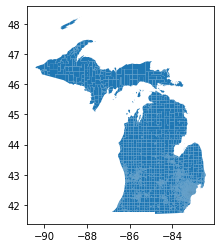

In [77]:
join = gpd.GeoDataFrame(pd.merge(final_election, shp, on = 'VTD2016', how = 'outer').drop_duplicates(), crs = crs)
join.plot()

In [78]:
join.shape

(4810, 27)

# Validation

## Shapefile

In [79]:
shp_final_merge = pd.merge(join, gdfv, on = 'VTD2016', how = 'outer', suffixes = ['_x', '_y'], indicator = True)

In [82]:
shp_shapes = gpd.GeoDataFrame(shp_final_merge, geometry = 'geometry_x')
final_shapes = gpd.GeoDataFrame(shp_final_merge, geometry = 'geometry_y')
vals = shp_shapes.geom_almost_equals(final_shapes, decimal = 0)

In [83]:
print(vals.value_counts())

True     4758
False      52
dtype: int64


In [84]:
both = shp_final_merge[shp_final_merge["_merge"]=="both"]
source_geoms = gpd.GeoDataFrame(both,geometry="geometry_x",crs=gdfv.crs)
vest_geoms = gpd.GeoDataFrame(both,geometry="geometry_y",crs=gdfv.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    4810
dtype: int64


In [ ]:
count = 0
area_list = []
big_diff = pd.DataFrame(columns=["area"])
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > 1):
        count += 1
        name = source_geoms.at[i,"join_col"]
        big_diff.loc[name]=area
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [ ]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and 0.1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=0.1)]))+ " precincts w/ a difference between 0.1 and 0.5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=0.5)]))+ " precincts w/ a difference between 0.5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")